In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
x=pd.read_csv(r"project_pagerank\mymoviedb.csv",usecols=["Title","Overview","Popularity","Vote_Count","Original_Language","Genre"],nrows=1105)

In [4]:
# x = x.dropna()  # Removes rows with ANY missing values

In [5]:
x.head

<bound method NDFrame.head of                                         Title  \
0                     Spider-Man: No Way Home   
1                                  The Batman   
2                                     No Exit   
3                                     Encanto   
4                              The King's Man   
...                                       ...   
1100                                Fireworks   
1101                              Hummingbird   
1102     HK: Hentai Kamen 2 - Abnormal Crisis   
1103                                   Rumble   
1104  Batman: The Dark Knight Returns, Part 1   

                                               Overview  Popularity  \
0     Peter Parker is unmasked and no longer able to...    5083.954   
1     In his second year of fighting crime, Batman u...    3827.658   
2     Stranded at a rest stop in the mountains durin...    2618.087   
3     The tale of an extraordinary family, the Madri...    2402.201   
4     As a collection of h

In [6]:
print(x["Original_Language"].nunique())

21


In [7]:
# x["Genre"] = x["Genre"].str.split(", ")
# x = x.explode("Genre")
# genre_counts = x["Genre"].value_counts()
# print(genre_counts)

In [8]:
# genre_counts = x["Genre"].value_counts()
# rare_genres = genre_counts[genre_counts < 10].index
# x = x[~x["Genre"].isin(rare_genres)]

In [9]:
print(x["Title"].duplicated().sum())  # Count duplicate movie titles

12


In [10]:
# x = x["Title"].drop_duplicates()

In [11]:
print(x.isnull().sum())

Title                0
Overview             0
Popularity           0
Vote_Count           0
Original_Language    0
Genre                0
dtype: int64


In [12]:
x.shape 

(1105, 6)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
x["combined_features"] = x["Genre"] + " " + x["Overview"]


In [15]:
tfidf = TfidfVectorizer(stop_words="english")  # Remove common stopwords
tfidf_matrix = tfidf.fit_transform(x["combined_features"])  # Convert text to numerical vectors

In [16]:
# print(tfidf)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
x["scaled_ratings"] = scaler.fit_transform(x[["Popularity"]])

In [19]:
import networkx as nx
G = nx.Graph()

In [20]:
for i, row in x.iterrows():
    G.add_node(row["Title"], rating=row["scaled_ratings"])
# G

In [21]:
threshold = 0.15
for i in range(len(x)):
    for j in range(i + 1, len(x)):
        if cosine_sim[i][j] > threshold:  # Only similarities
            weight = cosine_sim[i][j] * x["scaled_ratings"].iloc[i]  # Influence by rating
            G.add_edge(x["Title"].iloc[i], x["Title"].iloc[j], weight=weight)

In [22]:
print(f"Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")

Nodes: 1093, Edges: 608


In [23]:
for i in range(30):
    sample_movie = x["Title"].iloc[i]
    print(f"Edges for {sample_movie}: {list(G.edges(sample_movie, data=True))}")

Edges for Spider-Man: No Way Home: [('Spider-Man: No Way Home', 'The Amazing Spider-Man', {'weight': np.float64(0.1762587635936289)}), ('Spider-Man: No Way Home', 'The Amazing Spider-Man 2', {'weight': np.float64(0.18052954707919822)}), ('Spider-Man: No Way Home', 'Spider-Man: Far From Home', {'weight': np.float64(0.1920911544867564)}), ('Spider-Man: No Way Home', 'Spider-Man: Homecoming', {'weight': np.float64(0.19137660776545834)}), ('Spider-Man: No Way Home', 'Spider-Man', {'weight': np.float64(0.20881775202955927)}), ('Spider-Man: No Way Home', 'Spider-Man: Into the Spider-Verse', {'weight': np.float64(0.18955660162552246)}), ('Spider-Man: No Way Home', 'Spider-Man 3', {'weight': np.float64(0.17239743564794813)})]
Edges for The Batman: [('The Batman', 'Batman Begins', {'weight': np.float64(0.15808807242485334)}), ('The Batman', 'The Dark Knight Rises', {'weight': np.float64(0.13434429588097282)}), ('The Batman', 'The Dark Knight', {'weight': np.float64(0.1283671515729024)}), ('The 

In [24]:
### pagerank algo

In [25]:
def pagerank(G,d_f=0.85,max_iter=100,tol=1e-6):
    """
    Compute PageRank for a given graph using power iteration.
    returning pagerank score 
    """
    nodes = list(G.nodes())  # List of nodes (movies)
    N = len(nodes)  # Total number of nodes
    node_index = {node: i for i, node in enumerate(nodes)}  # Node to index mapping

    # Step 1: Initialize ranks
    ranks = np.ones(N) / N  # Start with equal ranks

    # Step 2: Create adjacency matrix with weights
    adj_matrix = np.zeros((N, N))

    for node in G.nodes():
        out_edges = list(G.edges(node, data=True))  # Get outgoing edges with weights
        if out_edges:
            total_weight = sum(weight["weight"] for _, _, weight in out_edges)  # Sum of edge weights
            for _, target, weight in out_edges:
                adj_matrix[node_index[target], node_index[node]] = weight["weight"] / total_weight  # Column-stochastic matrix

    # Step 3: Power Iteration Method
    for _ in range(max_iter):
        new_ranks = (1 - d_f) / N + d_f * np.dot(adj_matrix, ranks)  # PageRank formula
        
        # Convergence check
        if np.linalg.norm(new_ranks - ranks, ord=1) < tol:
            break

        ranks = new_ranks

    # Convert results to dictionary
    pagerank_scores = {nodes[i]: ranks[i] for i in range(N)}
    
    return pagerank_scores

In [26]:
pagerank_scores = pagerank(G)
print(pagerank_scores)

{'Spider-Man: No Way Home': np.float64(0.006233883981472668), 'The Batman': np.float64(0.007319641205066198), 'No Exit': np.float64(0.00013723696248856362), 'Encanto': np.float64(0.0019476998985771125), "The King's Man": np.float64(0.00013723696248856362), 'The Commando': np.float64(0.0009149130832570907), 'Scream': np.float64(0.004343255157610723), 'Kimi': np.float64(0.00013723696248856362), 'Fistful of Vengeance': np.float64(0.0020522436914828805), 'Eternals': np.float64(0.0021417241740390443), 'Pursuit': np.float64(0.00013723696248856362), "My Hero Academia: World Heroes' Mission": np.float64(0.001109074825916132), 'Restless': np.float64(0.00013723696248856362), 'Nightmare Alley': np.float64(0.00013723696248856362), 'The Ice Age Adventures of Buck Wild': np.float64(0.001260779118006757), 'Hotel Transylvania: Transformania': np.float64(0.003953119920186593), 'Texas Chainsaw Massacre': np.float64(0.0011698650811633074), 'The Requin': np.float64(0.001142908576852268), 'Looop Lapeta': n

In [27]:
# high=""
# max_val=0
# for i,j in pagerank_scores.items():
#     if max_val<j:
#         max_val=j
#         high=i

# print(high,max_val)
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
# print("Top 10 Movies by PageRank Score:")
# for movie, score in sorted_pagerank[:10]:
    # print(f"{movie}: {score:.5f}")

In [28]:
print("Top 10 Movies by PageRank Score:")
for movie, score in sorted_pagerank[:10]:
    print(f"{movie}: {score:.5f}")

Top 10 Movies by PageRank Score:
The Batman: 0.00732
Spider-Man: No Way Home: 0.00623
Scream: 0.00434
Hotel Transylvania: Transformania: 0.00395
Project X: 0.00318
Son: 0.00289
Raya and the Last Dragon: 0.00237
One Shot: 0.00236
The Simpsons in Plusaversary: 0.00228
Free Guy: 0.00228


C:\Users\psvma\AppData\Local\Temp\ipykernel_3260\660632927.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x800 with 0 Axes>

c:\Users\psvma\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


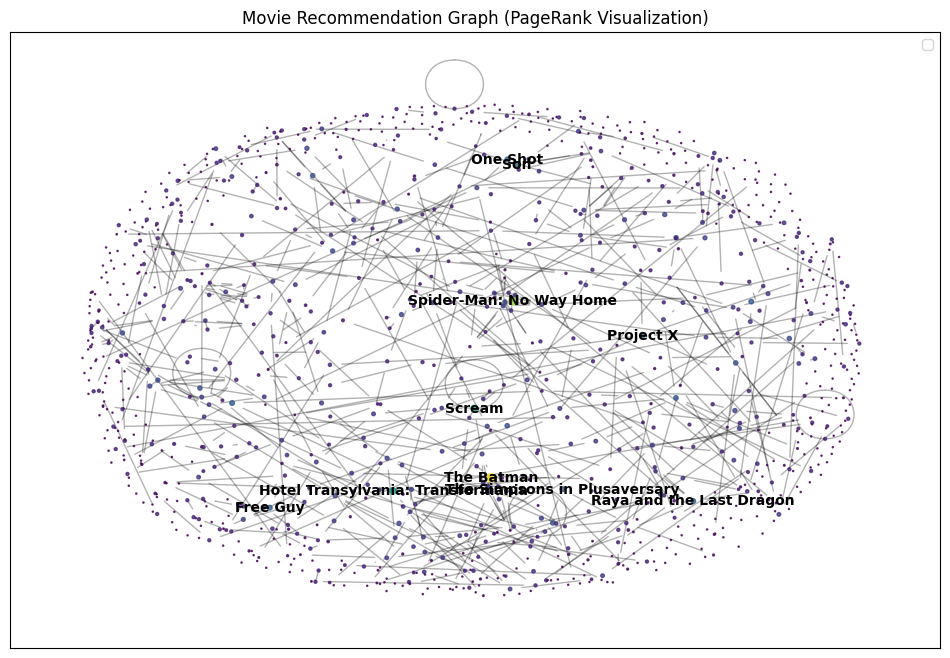

In [30]:
def draw_pagerank_graph(G, pagerank_scores):
    plt.figure(figsize=(12, 8))  # Set figure size
    
    # Node size based on PageRank score (scaled for visibility)
    node_sizes = [pagerank_scores[node] * 5000 for node in G.nodes()]
    
    # Node color based on PageRank score
    node_colors = [pagerank_scores[node] for node in G.nodes()]
    
    # Graph layout (spring layout for better spacing)
    pos = nx.spring_layout(G, seed=42)  
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.viridis,node_color=node_colors, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True)
    
    # Add labels only for top 10 ranked movies
    top_movies = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_movie_names = [movie for movie, score in top_movies]
    
    labels = {node: node if node in top_movie_names else "" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold")
    
    # Show colorbar for PageRank score intensity
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    # plt.colorbar(sm, label="PageRank Score")
    
    plt.title("Movie Recommendation Graph (PageRank Visualization)")
    plt.legend()
    plt.show()

# Draw the PageRank graph
draw_pagerank_graph(G, pagerank_scores)

In [31]:
def recommend_movies_by_genre(genres, pagerank_scores, movie_data, top_n=6):
    """
    recommend movies based on a given genre using PageRank scores.
    returning list of moives 
    """
    genres_lower = [g.lower() for g in genres]

    # filtered_movies = movie_data[movie_data["Genre"].str.contains(genre, case=False, na=False)]
    filtered_movies = movie_data[movie_data["Genre"].str.lower().apply(lambda x: any(g in x for g in genres_lower))]
    genre_pagerank = [(title, pagerank_scores[title]) for title in filtered_movies["Title"] if title in pagerank_scores]
    genre_pagerank_sorted = sorted(genre_pagerank, key=lambda x: x[1], reverse=True)
    return genre_pagerank_sorted[:top_n]

In [32]:
genre = ["Action"]  # Change to the genre you want
top_recommendations = recommend_movies_by_genre(genre, pagerank_scores, x)

print(f"Top {len(top_recommendations)} {genre} Movies Recommended:")
for movie, score in top_recommendations:
    print(f"{movie}: {score:.5f}")

Top 6 ['Action'] Movies Recommended:
Spider-Man: No Way Home: 0.00623
Raya and the Last Dragon: 0.00237
One Shot: 0.00236
Free Guy: 0.00228
Fistful of Vengeance: 0.00205
Dragon Ball Z: Cooler's Revenge: 0.00178


In [33]:
def recommendation_by_lan(lan,pagerank_scores,data,top_n=6):
    """
    recommending baesd on language of there intrest
    returning list of movies 
    """        
    filtered_movies = data[data["Original_Language"].str.contains(lan, case=False, na=False)]
    lan_pagerank = [(title, pagerank_scores[title]) for title in filtered_movies["Title"] if title in pagerank_scores]
    lan_pagerank_sorted = sorted(lan_pagerank, key=lambda x: x[1], reverse=True)
    return lan_pagerank_sorted[:top_n]


In [34]:
lan = "en"  # Change to the genre you want
top_recommendations = recommendation_by_lan(lan, pagerank_scores, x)

print(f"Top {len(top_recommendations)} {lan} Movies Recommended:")
for movie, score in top_recommendations:
    print(f"{movie}: {score:.5f}")

Top 6 en Movies Recommended:
The Batman: 0.00732
Spider-Man: No Way Home: 0.00623
Scream: 0.00434
Scream: 0.00434
Hotel Transylvania: Transformania: 0.00395
Project X: 0.00318
